# INT3 Practical 0: Machine learning refresher and an introduction to PyTorch

We will begin with a revision of the concepts of machine learning, loss functions and optimisation. We will use a trivial example to get started. We'll also see something new: the concept of differentiable programming using PyTorch. This makes a lot of what we want to do in machine learning extremely easy to implement.

*Machine learning* is a computational approach in which a system learns to map inputs to outputs by "learning" from training data. In reality, "learning" means *optimisation* (usually minimisation) of a *loss function*. In the case of *supervised learning* our training data provides pairs of inputs and the corresponding desired output. Our "machine" is a function of a particular form whose behaviour is determined by some parameters. Our job is to find the parameters that give a function that maps input to output such that the loss over the training set is minimised.

## A trivial example: the constant machine

Imagine a machine learning task where you need to predict a scalar value - i.e. the machine has a single output. Maybe we want to predict the height of people taking INT3. *But*, this machine has *zero inputs*. In that case, the machine must always predict the same single value. It's a very trivial machine that just always returns a constant since it has no input from which to change its behaviour. What would be the best value for the machine to always predict?

Simply the mean average! Or perhaps some other kind of average (depending on how you define ``centrality'' for your application).

You were taught the formula for computing the mean back in secondary school:

$$\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$$

You should all find it easy to compute this in python/numpy. Let's start by generating a dataset of 10 random numbers:

In [19]:
import matplotlib.pyplot as plt
import numpy as np

n = 9
x = np.random.rand(n)

and then compute the mean average:

In [20]:
mean = 1.0 / float(n) * np.sum(x)
print(mean)

0.4814660391292014


Of course, numpy has mean average as a built in function:

In [21]:
mean = np.mean(x)
print(mean)

0.4814660391292014


## Deriving the mean

So far so simple...

But do you know *why* that's the formula for the mean?

### Mean as optimisation problem

Actually, this formula is the solution to an optimisation problem. It is the value that minimises the squared differences to all data points:

$$\bar{x}=\arg\min_{\bar{x}} \sum_{i=1}^n (\bar{x}-x_i)^2$$

In other words, if we defined sum of squared differences as our loss function and solved the resulting optimisation problem, we would get the mean as the answer.

So, how is the formula we know for the mean derived from this optimisation problem? The answer is that this optimisation problem has a *closed form solution*. This means that we can write down an equation that solves it exactly, i.e. provides the *global optimum*. To do so, we only need A-level standard maths.

### Thought you'd never have to do differentiation again?

How do we minimise a function? We need to find the *stationary points* which we get by differentiating the function, setting to zero and solving. It's a bit of a painful process for the function above, but let's do it. Start by expanding the summation and square, then multiply out the brackets and collect like terms:

$$\begin{aligned}\sum_{i=1}^n (\bar{x}-x_i)^2 &= (\bar{x}-x_1)(\bar{x}-x_1) + \dots + (\bar{x}-x_n)(\bar{x}-x_n) \\ 
&= \bar{x}^2 - 2x_1\bar{x} + x_1^2 + \dots \bar{x}^2 - 2x_n\bar{x} + x_n^2 \\
&= n\bar{x}^2 - 2\bar{x}\sum_{i=1}^nx_i + \sum_{i=1}^nx_i^2\end{aligned}$$

In terms of $\bar{x}$, can you see what sort of function we have now? It's just a quadratic! i.e.

$$f(\bar{x}) = a\bar{x}^2 + b\bar{x} + c$$

where $a$, $b$ and $c$ happen to be:

$$a=n,\quad b=-2\sum_{i=1}^nx_i,\quad c=\sum_{i=1}^nx_i^2.$$

Now, hopefully you all remember how to differentiate $a\bar{x}^2 + b\bar{x} + c$? It's simply:

$$\frac{\partial f}{\partial \bar{x}} = 2a\bar{x} + b$$

Now set to zero and solve:

$$\begin{aligned}2a\bar{x} + b&=0\\
\bar{x}=\frac{-b}{2a}\end{aligned}$$

Now plug in $a$ and $b$:

$$\bar{x}=\frac{2\sum_{i=1}^nx_i}{2n}=\frac{1}{n} \sum_{i=1}^n x_i$$

It's the formula for the mean that we know and love!

**Wow - that was pretty painful right?!**

And that was for just about the most trivial machine learning problem you could possibly imagine (no inputs, one output, sum of squared errors as the loss). Consider a multilayer perceptron with many layers, nonlinear activation functions and a logistic regression layer on the end for classification. Imagine trying to differentiate that by hand! (And it wouldn't have a closed form solution anyway...)

## Differentiable programming

We'll now see a totally different way of solving optimisation problems (and it might mean you never have to do differentiation by hand again!) The idea is that we simply write code that computes the loss function, i.e. the thing we want to minimise, from some given input.

A differentiable programming language can then automatically differentiate backwards from our loss function, all the way through our series of instructions right back to the input(s). At any point through this chain of differentiation, we can ask: what is the gradient of the loss function with respect to some parameters at this point in the chain? And we can use this to optimise the loss function using gradient descent (or some other algorithm) automatically.

We're going to see a particular example of differentiable programming: PyTorch.

Let's repeat the above example but this time, instead of differentiating and solving by hand, we'll use differentiable programming in PyTorch and solve by iterative optimisation.

In [22]:
import torch

# Copy the sequence of numbers from numpy array to PyTorch tensor
xt = torch.from_numpy(x)

The above just imports the main PyTorch libraries and then copies the dataset x from a numpy array to a PyTorch **tensor**. These are very similar in that both are multidimensional arrays and can be indexed and sliced in similar ways. But PyTorch tensors can easily be transferred to a GPU (essential for processing large datasets quickly) and have many useful operations that are automatically differentiable. Tensors are the fundamental data type in PyTorch: every layer in our neural networks will take one or more tensors as input and output one or more tensors. We'll learn more about them later but that will do for now.

Let's get on with something more interesting: let's write some code to compute our loss function.

In [23]:
def sum_squared_differences(average, xt):
    loss = torch.sum((xt - average) ** 2.0)
    return loss

This function takes as input the current estimate of the mean value and the dataset as a tensor. All it does inside the function is compute the sum of squared errors between the estimate of the mean and all elements in the dataset. Notice how we used a PyTorch operation `torch.sum`? We could equally have used the sum method of the tensor to get the same effect:

`loss = ((xt-mean)**2.0).sum()`

There is no difference - it's just a matter of coding style and I will mix the two.

## Optimisation in PyTorch

We've written down our loss function, now it's time to iteratively optimise it. Like any iterative optimisation, we need an initialisation. Let's just use a random number for our initial guess at the mean. There's also a couple of other things we need to set up:

In [24]:
# Let's initialise our estimate of the mean randomly
average = torch.rand(1)
# We need to tell PyTorch that we need the gradient of the loss with respect to the mean
average.requires_grad = True
# Set up the optimiser and tell it that the variable to optimise is the mean
optim = torch.optim.SGD([average], lr=0.01)

`optim` is now an optimiser object that will use the Stochastic Gradient Descent algorithm (the "stochastic" part only comes in when we talk about batching data - in this particular example it will just run normal gradient descent). We have to give it an iterable list containing the parameters to be optimised (in our case just `average` - and note that we had to set `requires_grad` to true because we need to know the gradient of the loss with respect to this parameter). Our optimiser has one hyperparameter: `lr` is the learning rate. I've set it to a value that should work ok. Now we're ready to optimise.

In [25]:
niter = 100
for step in range(niter):
    # Run forward pass to compute our loss function
    loss = sum_squared_differences(average, xt)
    # Reset the gradients in the optimiser object to zero
    optim.zero_grad()
    # MAGIC! (See below)
    loss.backward()
    # Update all parameters with one gradient descent step
    optim.step()
    if not step % 5:
        # Display iteration number, current loss and current estimate of the mean
        print("Step %d, loss %0.6f, mean %0.6f" % (step, loss, average))

Step 0, loss 0.976449, mean 0.576184
Step 5, loss 0.872871, mean 0.516582
Step 10, loss 0.858634, mean 0.494485
Step 15, loss 0.856678, mean 0.486293
Step 20, loss 0.856409, mean 0.483255
Step 25, loss 0.856372, mean 0.482129
Step 30, loss 0.856367, mean 0.481712
Step 35, loss 0.856366, mean 0.481557
Step 40, loss 0.856366, mean 0.481500
Step 45, loss 0.856366, mean 0.481479
Step 50, loss 0.856366, mean 0.481471
Step 55, loss 0.856366, mean 0.481468
Step 60, loss 0.856366, mean 0.481467
Step 65, loss 0.856366, mean 0.481466
Step 70, loss 0.856366, mean 0.481466
Step 75, loss 0.856366, mean 0.481466
Step 80, loss 0.856366, mean 0.481466
Step 85, loss 0.856366, mean 0.481466
Step 90, loss 0.856366, mean 0.481466
Step 95, loss 0.856366, mean 0.481466


The above code ran 100 iterations of gradient descent on our loss function, updating the estimate of the mean at each iteration. Compare the final value of the mean with what you got from the closed form numpy solution above. Are they the same?

They should be similar. They're not exact because we probably didn't run enough iterations (i.e. hadn't converged) and/or our learning rate is probably not optimal.

## Autograd

Something seriously magical happened in the above code. When we called loss.backward(), PyTorch automatically works backwards through our code, starting from `loss` and computing gradients via all tensors involved in the computation of the current loss value. At some point, this process reached `average`, where it was able to compute $\partial$ `loss`/$\partial$ `average`. This saved us all the pain from earlier of differentiating by hand. Once we had this, we were able to take a gradient descent step in the line `optim.step()`. This tells the optimiser to update everything that was passed to the optimiser as an optimisation variable. If you want to read more about autograd and how it works, see here:

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

## Summary

So, we've traded the pain of differentiating by hand for writing code to compute only the forward function. On the other hand, in this particular case we've lost the closed form solution and replaced it with something iterative, slower and dependent on hyperparameters (learning rate and number of iterations). But have we gained anything else? Yes! **Flexibility**.

If we now decide we want a different loss than sum of squared errors, we just change our code to compute something else. And it need not have a closed form solution. Let's use sum of absolute differences instead:

In [26]:
def sum_absolute_differences(average, xt):
    loss = (xt - average).abs().mean()
    return loss


niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average, xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))

Step 0, loss 0.264196, average 0.480355
Step 5, loss 0.263579, average 0.474799
Step 10, loss 0.262962, average 0.469244
Step 15, loss 0.262344, average 0.463688
Step 20, loss 0.261727, average 0.458133
Step 25, loss 0.261110, average 0.452577
Step 30, loss 0.260492, average 0.447021
Step 35, loss 0.259875, average 0.441466
Step 40, loss 0.259258, average 0.435910
Step 45, loss 0.258641, average 0.430355
Step 50, loss 0.258023, average 0.424799
Step 55, loss 0.257406, average 0.419243
Step 60, loss 0.256789, average 0.413688
Step 65, loss 0.256418, average 0.410354
Step 70, loss 0.256295, average 0.411466
Step 75, loss 0.256418, average 0.410354
Step 80, loss 0.256295, average 0.411466
Step 85, loss 0.256418, average 0.410354
Step 90, loss 0.256295, average 0.411466
Step 95, loss 0.256418, average 0.410354


Any idea what this just computed? It's a different kind of average... You might get a clue if we look at the original data in order:

In [27]:
print(xt.sort())

torch.return_types.sort(
values=tensor([0.0344, 0.1562, 0.2625, 0.3550, 0.4104, 0.4855, 0.7885, 0.8879, 0.9529],
       dtype=torch.float64),
indices=tensor([8, 2, 0, 1, 3, 5, 7, 4, 6]))


It's the median! (Or would be if the optimisation has converged). **Interesting eh?!** The median is also the solution to an optimisation problem, this time the sum of absolute differences.

In [28]:
print(np.median(x))

0.4103563206018723


## Tidying up

There's a few loose ends to tie up. First of all, PyTorch has lots of useful loss functions already built-in. For example "sum of absolute differences" would be called "L1 loss with sum reduction" in PyTorch. We could replace the definition of sum_absolute_differences with a built-in PyTorch loss:

`sum_absolute_differences = torch.nn.L1Loss(reduction='sum')`

The only difference is that where we actually compute the loss, we explicitly need to copy the average n times since the loss function expects two tensors the same size:

`loss = sum_absolute_differences(average.repeat(9),xt)`

In [29]:
sum_absolute_differences = torch.nn.L1Loss(reduction="sum")
niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average.repeat(9), xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))

Step 0, loss 2.306658, average 0.420354
Step 5, loss 2.316654, average 0.410354
Step 10, loss 2.306658, average 0.420354
Step 15, loss 2.316654, average 0.410354
Step 20, loss 2.306658, average 0.420354
Step 25, loss 2.316654, average 0.410354
Step 30, loss 2.306658, average 0.420354
Step 35, loss 2.316654, average 0.410354
Step 40, loss 2.306658, average 0.420354
Step 45, loss 2.316654, average 0.410354
Step 50, loss 2.306658, average 0.420354
Step 55, loss 2.316654, average 0.410354
Step 60, loss 2.306658, average 0.420354
Step 65, loss 2.316654, average 0.410354
Step 70, loss 2.306658, average 0.420354
Step 75, loss 2.316654, average 0.410354
Step 80, loss 2.306658, average 0.420354
Step 85, loss 2.316654, average 0.410354
Step 90, loss 2.306658, average 0.420354
Step 95, loss 2.316654, average 0.410354


## Things for you to try

It's time to do some experimentation yourself. 

1. What happens if you change the learning rate of the optimiser? 


In [30]:
# large learning rate
average = torch.rand(1)
average.requires_grad = True
optim_large_lr = torch.optim.SGD(
    [average], lr=0.15
)  # a learning rate that is probably way too large - expected outcome is not being able to find the minimum due to overshooting
niter = 100
for step in range(niter):
    # Run forward pass to compute our loss function
    loss = sum_squared_differences(average, xt)
    # Reset the gradients in the optimiser object to zero
    optim_large_lr.zero_grad()
    # MAGIC! (See below)
    loss.backward()
    # Update all parameters with one gradient descent step
    optim_large_lr.step()
    if not step % 5:
        # Display iteration number, current loss and current estimate of the mean
        print("Step %d, loss %0.6f, mean %0.6f" % (step, loss, average))

Step 0, loss 0.867228, mean 0.540524
Step 5, loss 3.046125, mean -0.357078
Step 10, loss 442.310847, mean 12.387597
Step 15, loss 88997.885635, mean -168.568634
Step 20, loss 17941758.348598, mean 2400.751953
Step 25, loss 3617048763.296261, mean -34079.933594
Step 30, loss 729195442640.344482, mean 483893.843750
Step 35, loss 147005465773860.937500, mean -6870596.000000
Step 40, loss 29636224836766828.000000, mean 97552672.000000
Step 45, loss 5974647379925635072.000000, mean -1385108608.000000
Step 50, loss 1204485530407161561088.000000, mean 19666565120.000000
Step 55, loss 242823807757344946782208.000000, mean -279237230592.000000
Step 60, loss 48953171295663586906472448.000000, mean 3964770975744.000000
Step 65, loss 9868939644358887661727907840.000000, mean -56294106988544.000000
Step 70, loss 1989573696492583607222002515968.000000, mean 799296098140160.000000
Step 75, loss 401097041890961937857716206698496.000000, mean -11348864816644096.000000
Step 80, loss 80861000838559568532

In [31]:
# small learning rate
# Let's initialise our estimate of the mean randomly
average = torch.rand(1)
# We need to tell PyTorch that we need the gradient of the loss with respect to the mean
average.requires_grad = True
# Set up the optimiser and tell it that the variable to optimise is the mean
optim_small_lr = torch.optim.SGD(
    [average], lr=0.0001
)  # a learning rate that is probably too small - expected outcome is not being able to reach a good loss value in 100 steps
niter = 100
for step in range(niter):
    # Run forward pass to compute our loss function
    loss = sum_squared_differences(average, xt)
    # Reset the gradients in the optimiser object to zero
    optim_small_lr.zero_grad()
    # MAGIC! (See below)
    loss.backward()
    # Update all parameters with one gradient descent step
    optim_small_lr.step()
    if not step % 5:
        # Display iteration number, current loss and current estimate of the mean
        print("Step %d, loss %0.6f, mean %0.6f" % (step, loss, average))

Step 0, loss 2.596151, mean 0.042588
Step 5, loss 2.565087, mean 0.046524
Step 10, loss 2.534578, mean 0.050424
Step 15, loss 2.504614, mean 0.054289
Step 20, loss 2.475184, mean 0.058120
Step 25, loss 2.446280, mean 0.061917
Step 30, loss 2.417893, mean 0.065679
Step 35, loss 2.390012, mean 0.069408
Step 40, loss 2.362629, mean 0.073103
Step 45, loss 2.335735, mean 0.076765
Step 50, loss 2.309320, mean 0.080394
Step 55, loss 2.283378, mean 0.083991
Step 60, loss 2.257899, mean 0.087555
Step 65, loss 2.232875, mean 0.091088
Step 70, loss 2.208297, mean 0.094588
Step 75, loss 2.184159, mean 0.098058
Step 80, loss 2.160451, mean 0.101496
Step 85, loss 2.137167, mean 0.104903
Step 90, loss 2.114298, mean 0.108280
Step 95, loss 2.091838, mean 0.111627


2. Can you think of other initialisation strategies? Using one of the input data points can be a good idea, but be careful. If you do, for example: `average = xt[0]`, you create a connection in the computational graph between `average` and `xt[0]` so the behaviour of the optimisation will not be as you expect (the value of `xt[0]` will change during the optimisation). Instead you could use: `average = xt[0].clone()`. This creates a new tensor containing the value that was in `xt[0]`.

In [32]:
# initialising with one of the values of x
average = xt[0].clone()
average.requires_grad = True
sum_absolute_differences = torch.nn.L1Loss(reduction="sum")
optim = torch.optim.SGD([average], lr=0.01)
niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average.repeat(9), xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))
print(f"Actual mean: {x.mean()}")

Step 0, loss 2.639388, average 0.302544
Step 5, loss 2.334468, average 0.392544
Step 10, loss 2.308843, average 0.402544
Step 15, loss 2.314468, average 0.412544
Step 20, loss 2.308843, average 0.402544
Step 25, loss 2.314468, average 0.412544
Step 30, loss 2.308843, average 0.402544
Step 35, loss 2.314468, average 0.412544
Step 40, loss 2.308843, average 0.402544
Step 45, loss 2.314468, average 0.412544
Step 50, loss 2.308843, average 0.402544
Step 55, loss 2.314468, average 0.412544
Step 60, loss 2.308843, average 0.402544
Step 65, loss 2.314468, average 0.412544
Step 70, loss 2.308843, average 0.402544
Step 75, loss 2.314468, average 0.412544
Step 80, loss 2.308843, average 0.402544
Step 85, loss 2.314468, average 0.412544
Step 90, loss 2.308843, average 0.402544
Step 95, loss 2.314468, average 0.412544
Actual mean: 0.4814660391292014


In [33]:
# initialising with zero
average = torch.zeros(1)
average.requires_grad = True
sum_absolute_differences = torch.nn.L1Loss(reduction="sum")
optim = torch.optim.SGD([average], lr=0.01)
niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average.repeat(9), xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))
print(f"Actual mean: {x.mean()}")

Step 0, loss 4.333194, average 0.090000
Step 5, loss 2.497020, average 0.340000
Step 10, loss 2.317012, average 0.410000
Step 15, loss 2.307012, average 0.420000
Step 20, loss 2.316300, average 0.410000
Step 25, loss 2.307012, average 0.420000
Step 30, loss 2.316300, average 0.410000
Step 35, loss 2.307012, average 0.420000
Step 40, loss 2.316300, average 0.410000
Step 45, loss 2.307012, average 0.420000
Step 50, loss 2.316300, average 0.410000
Step 55, loss 2.307012, average 0.420000
Step 60, loss 2.316300, average 0.410000
Step 65, loss 2.307012, average 0.420000
Step 70, loss 2.316300, average 0.410000
Step 75, loss 2.307012, average 0.420000
Step 80, loss 2.316300, average 0.410000
Step 85, loss 2.307012, average 0.420000
Step 90, loss 2.316300, average 0.410000
Step 95, loss 2.307012, average 0.420000
Actual mean: 0.4814660391292014


3. Think up some different loss functions and try replacing sum of squared/absolute differences with these. Does changing from sum to mean reduction make a difference to the minimum obtained?

In [34]:
# using mean instead of sum in the loss function
average = torch.rand(1)
average.requires_grad = True
sum_absolute_differences = torch.nn.L1Loss(reduction="mean")
optim = torch.optim.SGD([average], lr=0.01)
niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average.repeat(9), xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))
print(f"Actual mean: {x.mean()}")

Step 0, loss 0.256537, average 0.409287
Step 5, loss 0.256414, average 0.410399
Step 10, loss 0.256300, average 0.409287
Step 15, loss 0.256414, average 0.410399
Step 20, loss 0.256300, average 0.409287
Step 25, loss 0.256414, average 0.410399
Step 30, loss 0.256300, average 0.409287
Step 35, loss 0.256414, average 0.410399
Step 40, loss 0.256300, average 0.409287
Step 45, loss 0.256414, average 0.410399
Step 50, loss 0.256300, average 0.409287
Step 55, loss 0.256414, average 0.410399
Step 60, loss 0.256300, average 0.409287
Step 65, loss 0.256414, average 0.410399
Step 70, loss 0.256300, average 0.409287
Step 75, loss 0.256414, average 0.410399
Step 80, loss 0.256300, average 0.409287
Step 85, loss 0.256414, average 0.410399
Step 90, loss 0.256300, average 0.409287
Step 95, loss 0.256414, average 0.410399
Actual mean: 0.4814660391292014


4. Extra challenge: Find the minimum of the following function:
```python
def smooth_2d_function(x, y):
  z = -(
      torch.exp(-(x - 2) ** 2 - (y - 2) ** 2) +
      2 * torch.exp(-(x + 2) ** 2 - (y + 2) ** 2)
  )
  return z
```
Note that this function depends on two variables. You will therefore need to initialise two variables that have requires_grad=True and pass both variables to the optimiser. Since you want to directly minimise the function itself, you don't need any additional loss function. Instead, you can simply optimise the value of this function directly using the same strategy you used to minimise a loss function in the previous exercises. What values did you find for the minimum? Do you get different results with different initialisations?

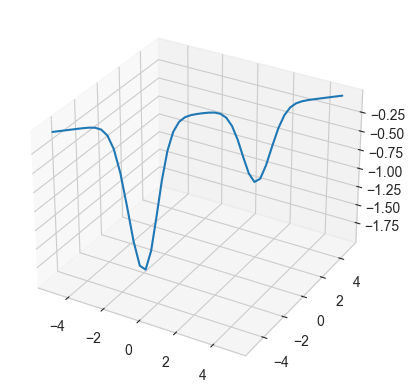

In [43]:
import seaborn as sns


def smooth_2d_function(x, y):
    z = -(
        torch.exp(-((x - 2) ** 2) - (y - 2) ** 2)
        + 2 * torch.exp(-((x + 2) ** 2) - (y + 2) ** 2)
    )
    return z


x = torch.from_numpy(np.linspace(-5, 5))
y = torch.from_numpy(np.linspace(-5, 5))
z = smooth_2d_function(x, y)
sns.set_style("whitegrid")

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(x, y, z)